In [262]:
# conda activate hockey_goals
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from dash import Dash, dash_table
from itables import show



# Load Data
Data from https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-03-03

In [220]:
season_goals = pd.read_csv(r'./data/season_goals.csv')
season_goals["season"] = pd.to_numeric(season_goals["season"].str[0:4])

game_goals = pd.read_csv(r'./data/game_goals.csv')
top_250 = pd.read_csv(r'./data/top_250.csv')
top_250.head()

,raw_rank,player,years,total_goals,url_number,raw_link,link,active,yr_start
0,1.0,Wayne Gretzky,1979-99,894,1,/players/g/gretzwa01.html,https://www.hockey-reference.com/players/g/gre...,Retired,1979
1,2.0,Gordie Howe,1946-80,801,2,/players/h/howego01.html,https://www.hockey-reference.com/players/h/how...,Retired,1946
2,3.0,Jaromir Jagr,1990-18,766,3,/players/j/jagrja01.html,https://www.hockey-reference.com/players/j/jag...,Retired,1990
3,4.0,Brett Hull,1986-06,741,4,/players/h/hullbr01.html,https://www.hockey-reference.com/players/h/hul...,Retired,1986
4,5.0,Marcel Dionne,1971-89,731,5,/players/d/dionnma01.html,https://www.hockey-reference.com/players/d/dio...,Retired,1971


# Look at Goal Production by Year
- Are top ranked scorers more likely to play before 2000?

## Are top ranked scorers more likely to play before 2000?
To examine this question we will classify players as finishing their career before 2000 or not. Then we will look at boxplots and summary stats to see if players before 2000 scored more goals.

In [57]:
top_250["yr_retired"] = np.where(top_250["years"].str[5:7].astype(int) <= 20, "20" + top_250["years"].str[5:7], top_250["years"].str[0:2] + top_250["years"].str[5:7]).astype(int)

top_250["career_pre2000"] = np.where(top_250["yr_retired"] < 2000, True, False)

top_250.head()

,raw_rank,player,years,total_goals,url_number,raw_link,link,active,yr_start,yr_retired,career_pre2000
0,1.0,Wayne Gretzky,1979-99,894,1,/players/g/gretzwa01.html,https://www.hockey-reference.com/players/g/gre...,Retired,1979,1999,True
1,2.0,Gordie Howe,1946-80,801,2,/players/h/howego01.html,https://www.hockey-reference.com/players/h/how...,Retired,1946,1980,True
2,3.0,Jaromir Jagr,1990-18,766,3,/players/j/jagrja01.html,https://www.hockey-reference.com/players/j/jag...,Retired,1990,2018,False
3,4.0,Brett Hull,1986-06,741,4,/players/h/hullbr01.html,https://www.hockey-reference.com/players/h/hul...,Retired,1986,2006,False
4,5.0,Marcel Dionne,1971-89,731,5,/players/d/dionnma01.html,https://www.hockey-reference.com/players/d/dio...,Retired,1971,1989,True


In [58]:
print(top_250.columns.tolist())

['raw_rank', 'player', 'years', 'total_goals', 'url_number', 'raw_link', 'link', 'active', 'yr_start', 'yr_retired', 'career_pre2000']


In [59]:
top_250[["total_goals"]].groupby(top_250['career_pre2000']).mean()

,total_goals
career_pre2000,
False,403.094203
True,400.964602


In [60]:
top_250[["total_goals"]].groupby(top_250['career_pre2000']).std()

,total_goals
career_pre2000,
False,113.202028
True,120.317506


<Axes: xlabel='career_pre2000', ylabel='total_goals'>

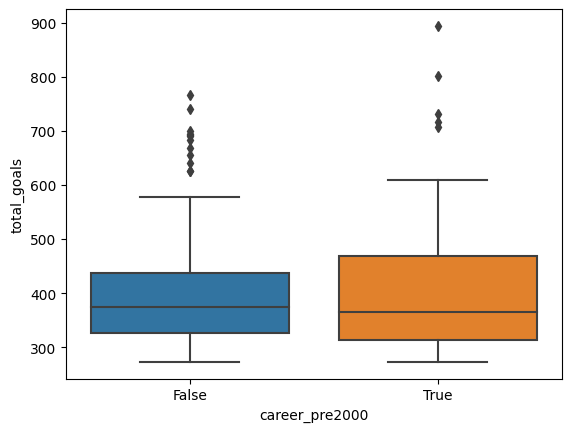

In [61]:
sns.boxplot(x='career_pre2000', y='total_goals', data=top_250)


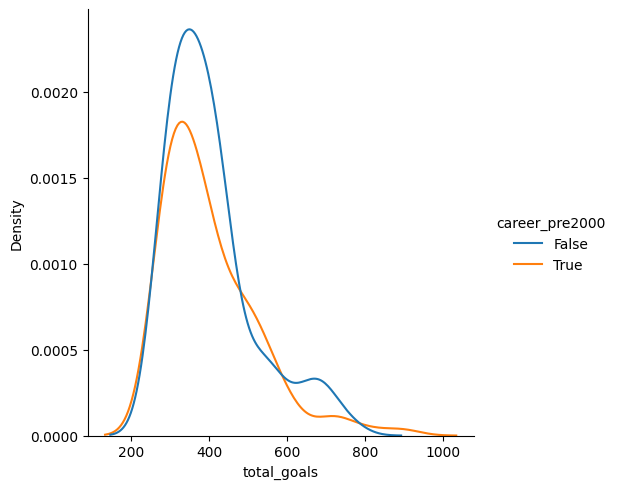

In [62]:
sns.displot(x='total_goals', data=top_250,
            hue="career_pre2000", kind="kde")

<Axes: xlabel='career_pre2000', ylabel='raw_rank'>

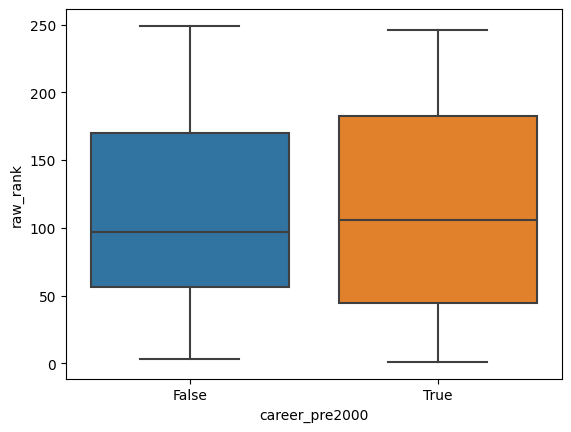

In [70]:
sns.boxplot(x='career_pre2000', y='raw_rank', data=top_250)

In [69]:
stats.ttest_ind(top_250[top_250["career_pre2000"] == True]["total_goals"],
                top_250[top_250["career_pre2000"] == False]["total_goals"])

Ttest_indResult(statistic=-0.1441374755130994, pvalue=0.8855085006098049)

> Answer: Players with careers before 2000 did not score more goals than those who play during the 2000s. However, the top ranking goal scorers did play before 2000

# What factors are associated with scoring more goals
- Which teams score more goals?
- Does goal production decrease with age? 
- Which players have the best shot percentage? 

## Which teams score more goals?

In [124]:
game_goals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49384 entries, 0 to 49383
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player             49384 non-null  object 
 1   season             49384 non-null  int64  
 2   rank               49384 non-null  int64  
 3   date               49384 non-null  object 
 4   game_num           49384 non-null  int64  
 5   age                49384 non-null  object 
 6   team               49384 non-null  object 
 7   at                 24584 non-null  object 
 8   opp                49384 non-null  object 
 9   location           49384 non-null  object 
 10  outcome            49384 non-null  object 
 11  goals              49384 non-null  int64  
 12  assists            49384 non-null  int64  
 13  points             49384 non-null  int64  
 14  plus_minus         49384 non-null  int64  
 15  penalty_min        49384 non-null  int64  
 16  goals_even         493

In [94]:
game_goals['win'] = np.where(game_goals['outcome'] == "W", True, False)
game_goals.groupby(['win']).agg({'win': 'count'})

In [114]:
df = game_goals.groupby(["team", "season"]).agg({'points': 'sum',
                                            'goals': 'sum',
                                            'assists': 'sum',
                                            'shots': 'sum',
                                            'shot_percent': 'mean',
                                            'win': 'sum'
                                            }).reset_index()

In [115]:
df.head(20)

,team,season,points,goals,assists,shots,shot_percent,win
0,ANA,2007,196,90,106,654,13.631579,144
1,ANA,2008,159,65,94,472,14.623602,103
2,ANA,2009,217,84,133,696,13.535922,117
3,ANA,2010,193,73,120,592,12.621429,97
4,ANA,2011,254,100,154,620,15.536000,127
5,ANA,2012,183,74,109,672,9.452466,101
6,ANA,2013,109,42,67,323,13.847541,83
7,ANA,2014,196,83,113,595,13.949500,145
8,ANA,2015,125,58,67,384,12.933846,93
9,ANA,2016,125,47,78,393,11.216327,89


In [122]:
df.groupby('team')['team'].count()

team
ANA    14
ARI     1
ATL     8
BOS    22
BUF    12
CAR    15
CBJ     1
CGY    20
CHI    13
COL    16
DAL    15
DET    22
EDM    13
FLA     5
HAR     2
LAK    30
MDA     7
MIN     8
MNS    10
MTL    11
NJD    18
NSH     3
NYI     9
NYR    18
OTT    11
PHI    11
PHX     3
PIT    35
QUE     7
SJS    22
STL    11
TBL    18
TOR    13
VAN     3
VEG     3
WIN     4
WSH    31
Name: team, dtype: int64

In [ ]:
game_goals.groupby('team')['team'].count()

Looks like there are some teams with much less data. Some of that can be related to number of seasons played but maybe only the top 250 players data in the database. Therefore, we will not continue to examine the question `Which teams score more goals?`

## Does goal production decrease with age?

<Axes: xlabel='age', ylabel='goals'>

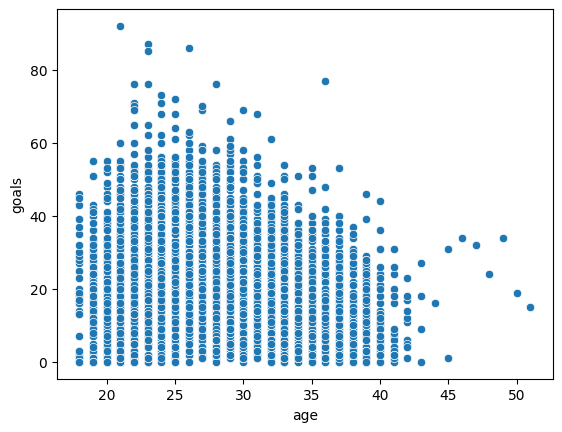

In [126]:
sns.scatterplot(data=season_goals, x="age", y="goals")

The total number of goals may not be the best metric to use because players participant in a different number of games each season. Will create a variable `goals_pg` that is the number of goals per game that season.

<Axes: xlabel='age', ylabel='goals_pg'>

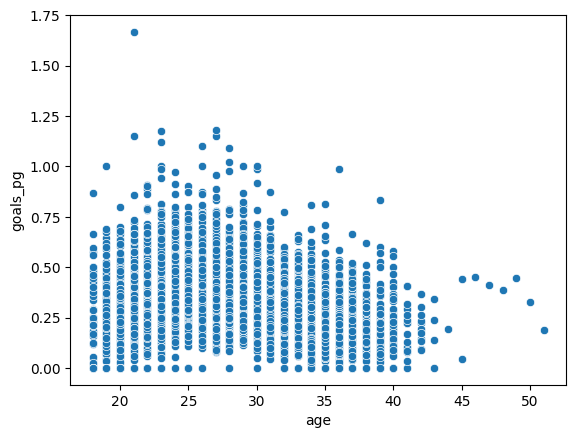

In [127]:
season_goals['goals_pg'] = season_goals['goals'] / season_goals['season_games']
sns.scatterplot(data=season_goals, x="age", y="goals_pg")

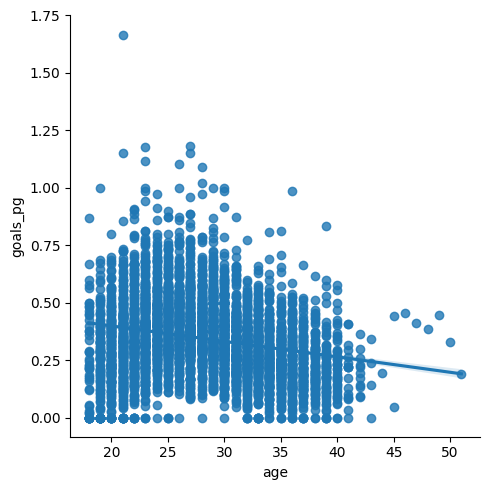

In [128]:
sns.lmplot(data=season_goals, x="age", y="goals_pg")

Looking here it looks like goals increase around age 25 and are lower before age 20 and after age 30. To confirm will build a mixed effect model with player as a random effect and polynomial of age as fixed effect.

In [159]:
m1_linear = smf.mixedlm("goals_pg ~ age", season_goals, groups=season_goals["player"], vc_formula = {"age" : "0 + C(age)"},) # random intercept of player and linear effect of age
m1_linear_fit = m1_linear.fit()
print(m1_linear_fit.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: goals_pg 
No. Observations: 4810    Method:             REML     
No. Groups:       251     Scale:              0.0115   
Min. group size:  10      Log-Likelihood:     2042.0123
Max. group size:  34      Converged:          Yes      
Mean group size:  19.2                                 
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    0.528    0.013  41.085 0.000  0.503  0.553
age         -0.006    0.000 -14.114 0.000 -0.007 -0.005
age Var      0.015    0.014                            



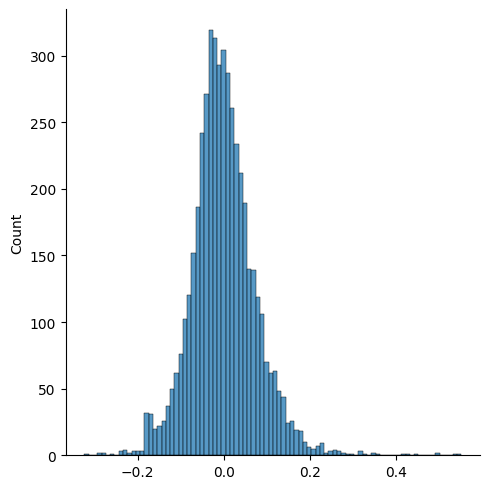

In [160]:
sns.displot(m1_linear_fit.resid, kind = "hist")

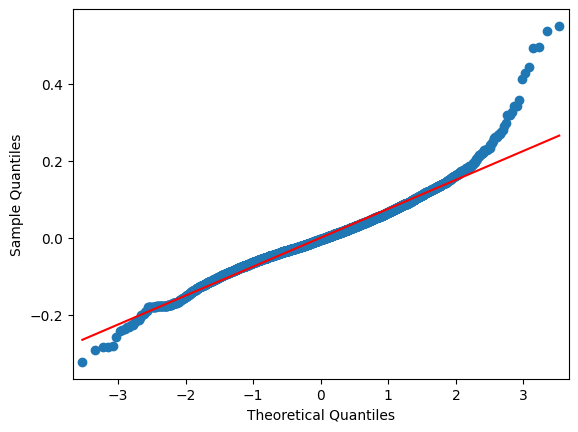

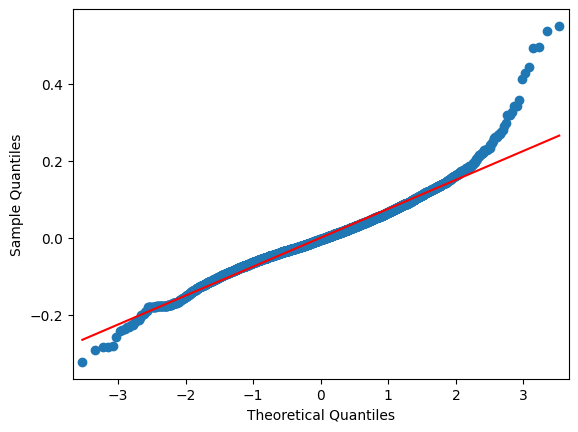

In [161]:
sm.qqplot(m1_linear_fit.resid, dist = stats.norm, line = 's')

In [162]:
labels = ["Statistic", "p-value"]

norm_res = stats.shapiro(m1_linear_fit.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)

Statistic 0.9674066305160522
p-value 1.113209959797923e-31


<Axes: >

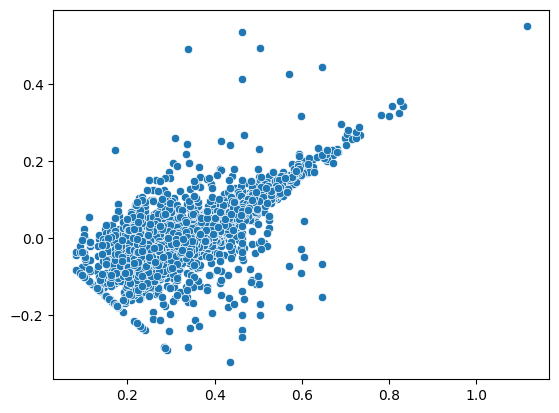

In [163]:
sns.scatterplot(y = m1_linear_fit.resid, x = m1_linear_fit.fittedvalues)


<Axes: >

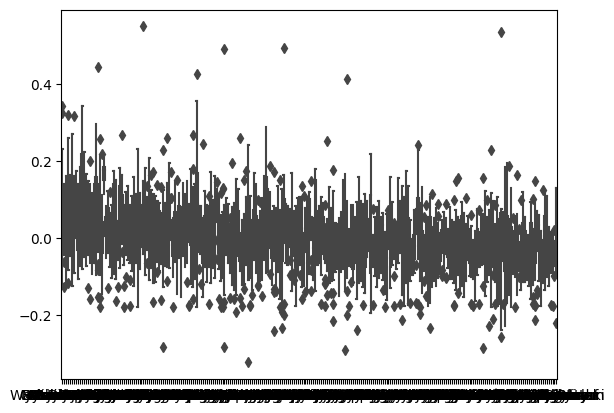

In [164]:
sns.boxplot(x = m1_linear_fit.model.groups, y = m1_linear_fit.resid)

In [151]:
m1_poly = smf.mixedlm("goals_pg ~ age + I(age**2)", vc_formula = {"age" : "0 + C(age)"},
                      data = season_goals, groups=season_goals["player"]) # random intercept of player and random slope of age (uncorrelated)
m1_poly_fit = m1_poly.fit()
print(m1_poly_fit.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: goals_pg 
No. Observations: 4810    Method:             REML     
No. Groups:       251     Scale:              0.0113   
Min. group size:  10      Log-Likelihood:     2159.6922
Max. group size:  34      Converged:          Yes      
Mean group size:  19.2                                 
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   -0.352    0.056  -6.285 0.000 -0.462 -0.242
age          0.057    0.004  14.416 0.000  0.049  0.065
I(age ** 2) -0.001    0.000 -16.118 0.000 -0.001 -0.001
age Var      0.014    0.013                            



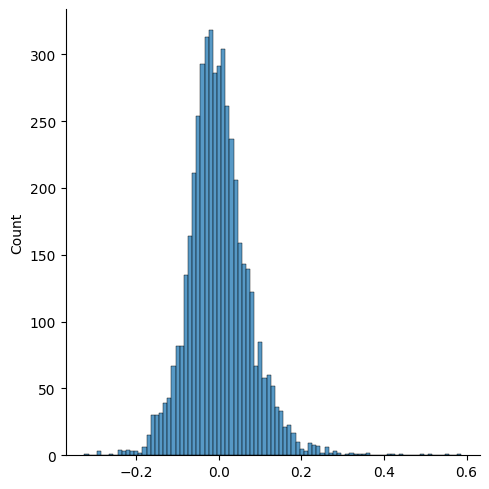

In [154]:
sns.displot(m1_poly_fit.resid, kind = "hist")

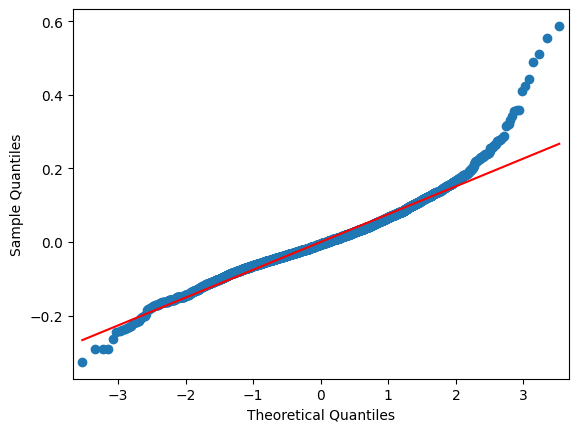

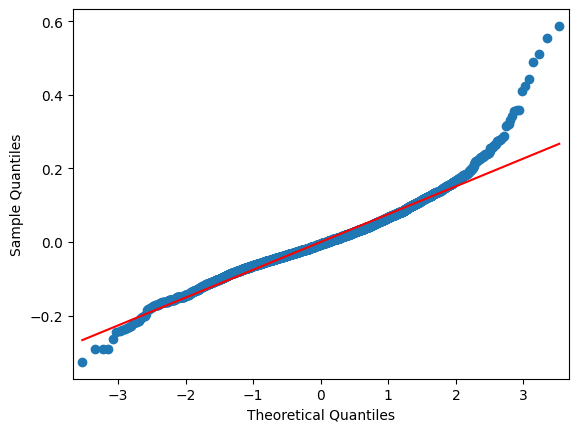

In [155]:
sm.qqplot(m1_poly_fit.resid, dist = stats.norm, line = 's')

In [156]:
labels = ["Statistic", "p-value"]

norm_res = stats.shapiro(m1_poly_fit.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)

Statistic 0.9619925022125244
p-value 9.093165120480426e-34


<Axes: >

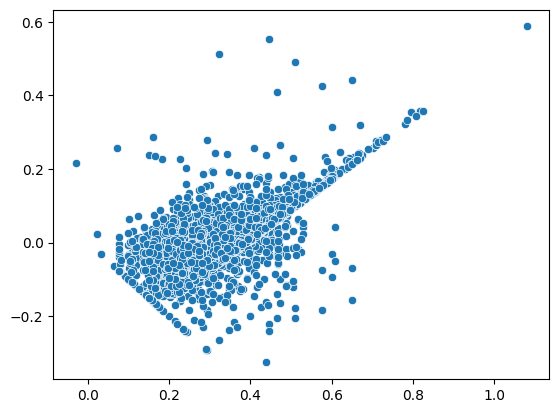

In [157]:
sns.scatterplot(y = m1_poly_fit.resid, x = m1_poly_fit.fittedvalues)


<Axes: >

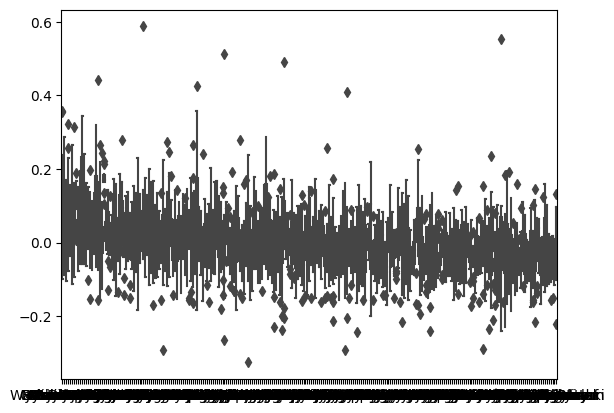

In [158]:
sns.boxplot(x = m1_poly_fit.model.groups, y = m1_poly_fit.resid)


In [186]:
season_goals['pred'] = m1_poly_fit.predict()

[(0.0, 2.0)]

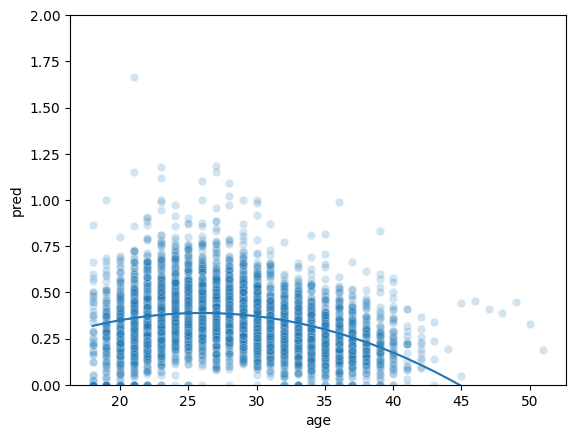

In [193]:
sns.lineplot(season_goals, x = "age", y = "pred")
a_plot = sns.scatterplot(season_goals, x = "age", y = "goals_pg", alpha=0.2)
a_plot.set(ylim=(0, 2))

> Answer: Goal production does go down with age in a non-linear fashion.

# Which players have the best shot percentage? 

In [235]:
shot_percent = game_goals.groupby(["player", "season"]).agg({'points': 'sum',
                                            'goals': 'sum',
                                            'assists': 'sum',
                                            'shots': 'sum',
                                            'shot_percent': 'mean'
                                            }).reset_index()

In [236]:
shot_percent.head()


,player,season,points,goals,assists,shots,shot_percent
0,Alex Ovechkin,2006,106,52,54,425,13.427500
1,Alex Ovechkin,2007,92,46,46,392,13.460976
2,Alex Ovechkin,2008,112,65,47,446,14.779012
3,Alex Ovechkin,2009,110,56,54,528,10.793671
4,Alex Ovechkin,2010,109,50,59,368,14.861972


In [237]:
shot_percent = pd.merge(shot_percent, season_goals[['player', 'season', 'age']], on=["player", "season"], how = 'left')
shot_percent.head()

,player,season,points,goals,assists,shots,shot_percent,age
0,Alex Ovechkin,2006,106,52,54,425,13.427500,21.0
1,Alex Ovechkin,2007,92,46,46,392,13.460976,22.0
2,Alex Ovechkin,2008,112,65,47,446,14.779012,23.0
3,Alex Ovechkin,2009,110,56,54,528,10.793671,24.0
4,Alex Ovechkin,2010,109,50,59,368,14.861972,25.0


In [238]:
shot_percent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 0 to 749
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player        750 non-null    object 
 1   season        750 non-null    int64  
 2   points        750 non-null    int64  
 3   goals         750 non-null    int64  
 4   assists       750 non-null    int64  
 5   shots         750 non-null    int64  
 6   shot_percent  750 non-null    float64
 7   age           685 non-null    float64
dtypes: float64(2), int64(5), object(1)
memory usage: 52.7+ KB


Age has some missing values, we will fill those in by adding +1 to the previous age value

In [239]:
shot_percent['age'] = shot_percent['age'].fillna(method = 'ffill')

In [240]:
shot_percent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 0 to 749
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player        750 non-null    object 
 1   season        750 non-null    int64  
 2   points        750 non-null    int64  
 3   goals         750 non-null    int64  
 4   assists       750 non-null    int64  
 5   shots         750 non-null    int64  
 6   shot_percent  750 non-null    float64
 7   age           750 non-null    float64
dtypes: float64(2), int64(5), object(1)
memory usage: 52.7+ KB


In [241]:
shot_percent.head()

,player,season,points,goals,assists,shots,shot_percent,age
0,Alex Ovechkin,2006,106,52,54,425,13.427500,21.0
1,Alex Ovechkin,2007,92,46,46,392,13.460976,22.0
2,Alex Ovechkin,2008,112,65,47,446,14.779012,23.0
3,Alex Ovechkin,2009,110,56,54,528,10.793671,24.0
4,Alex Ovechkin,2010,109,50,59,368,14.861972,25.0


In [265]:
top_perc = shot_percent.groupby(["player"]).agg({
                                            'goals': 'sum',
                                            'shots': 'sum',
                                            'shot_percent': 'median'
                                            }).reset_index()


# top_perc = shot_percent.groupby('player')['shot_percent', 'shots', 'goals'].median().reset_index()

In [266]:
top_perc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player        42 non-null     object 
 1   goals         42 non-null     int64  
 2   shots         42 non-null     int64  
 3   shot_percent  42 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.4+ KB


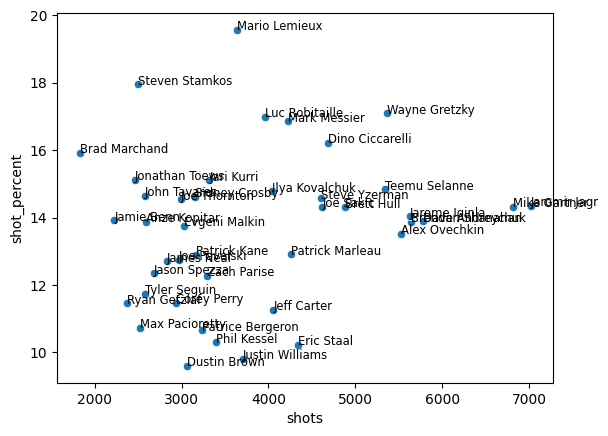

In [270]:
p = sns.scatterplot(data = top_perc, x = "shots", y = "shot_percent")

for name in range(0,top_perc.shape[0]):
     p.text(top_perc.shots[name]+0.2, top_perc.shot_percent[name], top_perc.player[name], horizontalalignment='left', size='small', color='black')

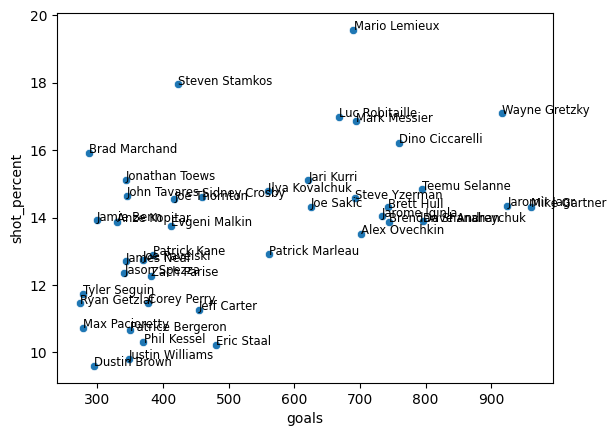

In [272]:
p2 = sns.scatterplot(data = top_perc, x = "goals", y = "shot_percent")

for name in range(0,top_perc.shape[0]):
     p2.text(top_perc.goals[name]+0.2, top_perc.shot_percent[name], top_perc.player[name], horizontalalignment='left', size='small', color='black')

There looks to be a separation of two groups 1) those with more than 600 goals and 2) those with fewer than 600 goals. Those with more than 600 goals appear to have a 15% or better shot percentage.

In [274]:
top_perc["gt_600_goals"] = np.where(top_perc["goals"] > 600, True, False)

<Axes: xlabel='gt_600_goals', ylabel='shot_percent'>

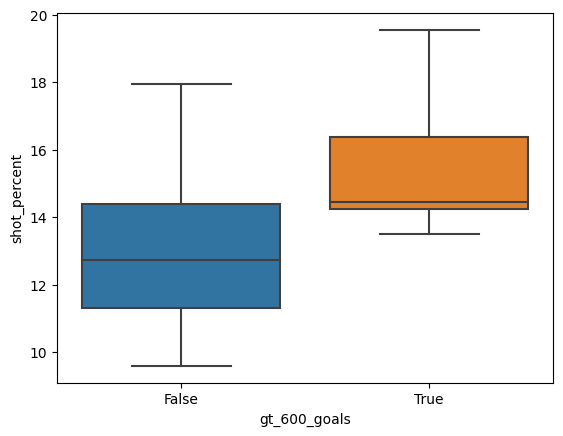

In [275]:
sns.boxplot(data = top_perc, x = 'gt_600_goals', y = 'shot_percent')

In [276]:
show(top_perc)

> Answer: Mario Lemieux	was the most effecient shooter, taking the fewest shots and having the highest percentage. 